# Investigation of the numpy.random package

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import binom
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" ## Ref [] to display all called variables in a cell
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
%run radar ## from [ref]

## Problem 1: Overall package purpose

Random number generators (RNG) in computing are used to generate pseudonrandom numbers for use in things like statistical sampling, cryptography and procedural generation.

"True" random numbers stem from analysis of an entropic systems such as, in the case of a computer, fan heat or the timing of keyboard pressing  [ref], which are considered disordered and unpredictable. This is in contrast with the pseudorandom numbers generated by algorithms, such as the one used in the numpy.random package. This package produces a sequence of seemingly random numbers which are in reality predetermined by a defining attribute known as a key, or seed, upon initialisation.



In [4]:
5 * np.random.random_sample((3, 2)) 

array([[1.44352454, 2.05513201],
       [1.75758725, 1.87901284],
       [4.86202401, 2.8787053 ]])

Text(0.5, 1.15, 'Charmander A')

Text(0.5, 1.15, 'Charmander B')

Text(0.5, 0.7, 'Charmander Individual Values')

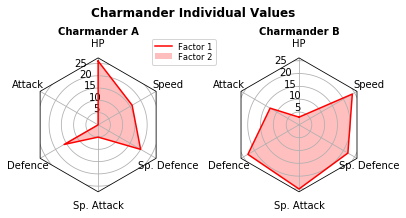

In [29]:
def character_data():
    data = [
        ['HP', 'Attack', 'Defence', 'Sp. Attack', 'Sp. Defence', 'Speed'],
        ('Charmander A', [
            np.random.randint(0, 31, size=6)]),
        ('Charmander B', [
            np.random.randint(0, 31, size=6)]),
]
    return data

if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    data = character_data()
    spoke_labels = data.pop(0)

    fig, axes = pl.subplots(figsize=(6, 6), ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

    colors = ['r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flat, data):
       # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.15),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0]
    labels = ('Factor 1', 'Factor 2',)
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.7, 'Charmander Individual Values',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    pl.show()

## Problem 2: Simple Random Data and Permutations

Simple random sampling is the most straightforward approach for getting a random sample. It involves picking a desired sample size and selecting observations from a population in such a way that each observation has an equal chance of selection until the desired sample size is achieved. [ref] Below, this notebook explores some of the numpy functions involved in creating simple random data.

### numpy.random.rand

Random values in the interval [0, 1)

(array([ 90., 111., 107., 101., 112.,  95., 103.,  89.,  98.,  94.]),
 array([0.00122862, 0.10086394, 0.20049926, 0.30013458, 0.3997699 ,
        0.49940521, 0.59904053, 0.69867585, 0.79831117, 0.89794649,
        0.99758181]),
 <a list of 10 Patch objects>)

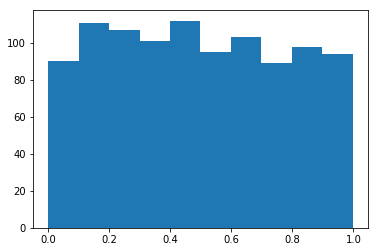

In [5]:
x = np.random.rand(1000)
pl.hist(x)

### numpy.random.randn¶

Random sample of normal/Gaussian distribution

In [6]:
np.random.randn()

-0.39658614456039865

In [7]:
2.5 * np.random.randn(2, 4) + 3

array([[2.33543476, 0.47283508, 1.61498345, 6.84782351],
       [4.2362287 , 1.94133818, 0.16278775, 5.75318137]])

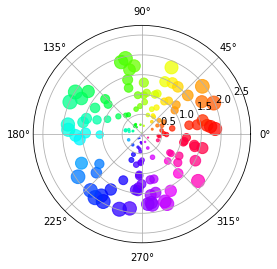

In [11]:
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 50 * r**2
colors = theta

fig = pl.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

### numpy.random.randint
Random integers, as seen in "Charmander Individual Values" above. 

In [8]:
np.random.randint(2, size=10)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

In [9]:
np.random.randint(1, size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
th = np.random.randint(0, 20, size=(10))
th

array([17, 14, 17,  2, 18, 16, 11, 10,  6,  3])

### Permutation

Permutations are arrangements of a set of values in a certain sequence or pattern, without repeating e.g a deck of cards.

In [12]:
np.random.permutation(10)
np.random.permutation([1, 4, 9, 12, 15])
arr = np.arange(9).reshape((3, 3))
np.random.permutation(arr)


array([6, 3, 1, 5, 7, 0, 2, 4, 8, 9])

array([ 4, 12,  9,  1, 15])

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

## Problem 3: Distributions

### Pareto

Also known as the 80-20 rule (sociology, economics etc.). This posits that wealth, for example, is distributed unevenly, with the top percentage (20%) hoard a disproportionate amount of monetary value (80%). While the exact percentages are malleable, the general concept of inequity remains the same. Other examples include the in business where 20% of customers account for 80% of revenue, and so on. The graph below demonstrates the weighted nature of this distribution.

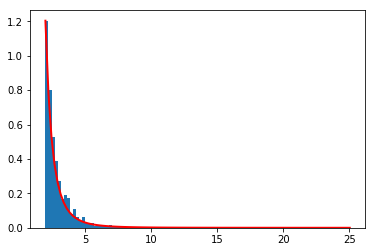

In [13]:
a, m = 3., 2.  # shape and mode
s = (np.random.pareto(a, 1000) + 1) * m
count, bins, _ = pl.hist(s, 100, density=True)
fit = a*m**a / bins**(a+1)
pl.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
pl.show()

### Laplace
E.g. Maximum one-day rainfall




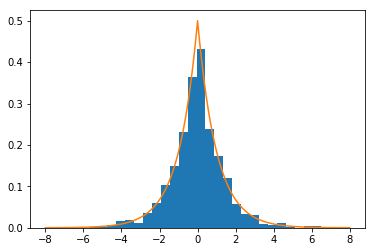

In [14]:
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
count, bins, ignored = pl.hist(s, 30, density=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
pl.plot(x, pdf)

### Binomial 

Probability of events with only two outcomes, yes or no e.g. flipping a coin

b(x; n, P) = nCx * Px * (1 – P)n – x

        b = binomial probability
        x = total number of “successes” (pass or fail, heads or tails etc.)
        P = probability of a success on an individual trial
        n = number of trials

In [47]:
crit = sum(np.random.binomial(10, 0.1, 1000) == 0)/1000
crit

0.326

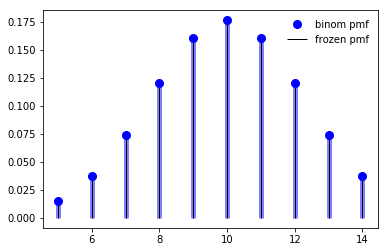

In [48]:
fig, ax = pl.subplots(1, 1)
n, p = 20, 0.5
x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
rv = binom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
pl.show()

### Poisson

Probability of events occuring if a constant rate is known and is independent of previous event e.g. phone calls, website crashes [ref]

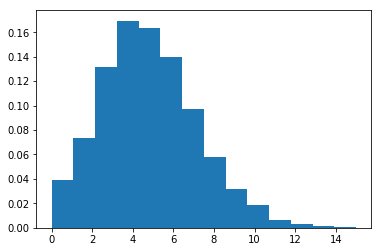

In [16]:
s = np.random.poisson(5, 10000)
count, bins, ignored = pl.hist(s, 14, density=True)
x = np.arange(0., 16., .01)
pl.show()

### Normal / Gaussian

A.K.A. the Bell Curve

A normal distribution is based on the mean of the distribution and the standard deviation from the mean. Aprroximately 68% of all events in a standard distribution are withing one standard deviation of the mean, while 95% are within two standard deviations and 99.7% within three.

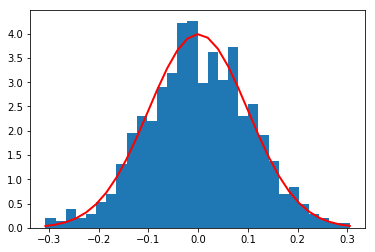

In [17]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = pl.hist(s, 30, density=True)
pl.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
pl.show()

## Problem 4: Seeds

Seeds are an attribute of random number generators decided at the time of import/initialisation. They determine the pattern which the "random" numbers will materialise. If the generator is initialized with the same seed in multiple instances, it will produce the same sequence of numbers each time, in adherence with various probability distributions. This is demonstrated below with the numpy.random.seed function used to set the seed.

In [18]:
x1 = np.random.randn(3, 3)
y1 = np.random.randn(3, 3)
x1
y1

array([[ 0.00486822,  0.52062579, -0.90137726],
       [-1.18119037,  1.34512033,  0.08301266],
       [ 1.66711244,  0.23125696,  0.25904707]])

array([[-0.94841759,  0.75732339, -1.30853402],
       [-0.26298801,  1.48807496,  0.42170392],
       [-0.02723132, -0.32697301,  0.36328146]])

In [19]:
np.random.seed(12)
x2 = np.random.randn(3, 3)
np.random.seed(12)
y2 = np.random.randn(3, 3)
x2
y2

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

The function numpy.random.randomstate can take a seed as a parameter. 

In [20]:
state = np.random.RandomState(12)
state.randn(3, 3)
state = np.random.RandomState(12)
state.randn(3, 3)
state.randn(3, 3)

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 0.47298583, -0.68142588,  0.2424395 ],
       [-1.70073563,  0.75314283, -1.53472134],
       [ 0.00512708, -0.12022767, -0.80698188]])

array([[ 2.87181939, -0.59782292,  0.47245699],
       [ 1.09595612, -1.2151688 ,  1.34235637],
       [-0.12214979,  1.01251548, -0.91386915]])

# References

https://matplotlib.org/gallery/specialty_plots/radar_chart.html - radar charts

https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs

https://www.howtogeek.com/183051/htg-explains-how-computers-generate-random-numbers/ - randomness/entropy etc.

https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459